# Wireless Drone Data Analysis

## 11-13-25 RX Coil Measurements
Measurements of the following RX coils:
- Coil 1: coil + 220 nF cap
- Coil 2: coil + 220 nF cap
    - identical to 1
- Coil 3: coil + header pins + 220 nF cap
- Coil 4: coil + 220 nF cap
    - identical to 1 and 2
- Coil 5: coil + header pins + 220 nF cap
    - identical to 3

each L has 8 windings with ~27 mm diameter, all capacitors are *not* C0G caps

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
def merge_data(file1, file2):
    df1 = pd.read_csv(file1, comment='#')
    df2 = pd.read_csv(file2, comment='#')

    freq = pd.concat([df1['Frequency (Hz)'], df2['Frequency (Hz)']])
    mag = pd.concat([df1['Channel 4 Magnitude (dB)'], df2['Channel 4 Magnitude (dB)']])

    sort_idx = freq.argsort()
    freq = freq.iloc[sort_idx]
    mag = mag.iloc[sort_idx]

    return freq, mag

In [79]:
def get_res_freq(freq, mag):
    idx = np.argmax(mag)
    return freq.iloc[idx]

In [97]:
def calc_ind(res, C=220*1e-9):
    return 1/(C*(2*np.pi*res)**2)

In [132]:
def get_Q_factor(freq, mag):
    freq = freq.to_numpy()
    mag = mag.to_numpy()
    
    peak_idx = np.argmax(mag)
    f_peak = freq[peak_idx]
    thresh = mag[peak_idx] - 3

    left_idxs = np.where(mag[:peak_idx] <= thresh)[0]
    f_left = freq[left_idxs[-1]]

    right_idxs = np.where(mag[peak_idx:] <= thresh)[0]
    f_right = freq[peak_idx + right_idxs[0]]

    return f_peak / (f_right - f_left)

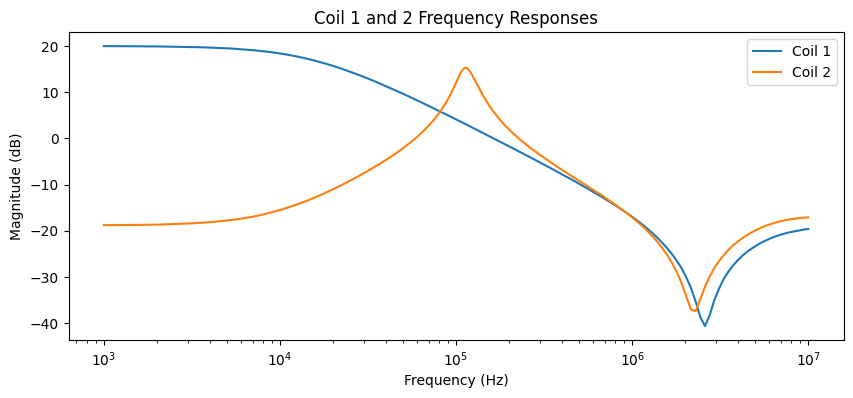

In [67]:
coil1 = pd.read_csv('LC_coils_11-13/coil1_freq.csv', comment='#')
# print(coil1.columns)
freq2, mag2 = merge_data('LC_coils_11-13/coil2_freq.csv', 'LC_coils_11-13/coil2_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(coil1['Frequency (Hz)'], coil1['Channel 4 Magnitude (dB)'], label='Coil 1')
plt.semilogx(freq2, mag2, label='Coil 2')
plt.title('Coil 1 and 2 Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

**Conclusion: Coil 1 capacitor (which was not C0G) has been fried**

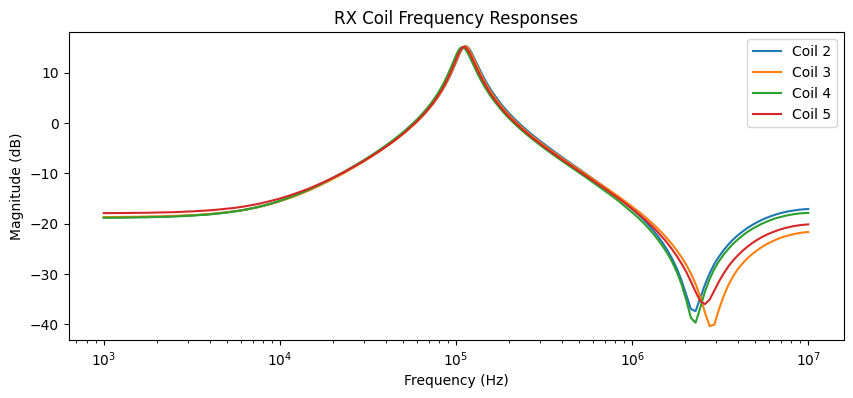

In [103]:
freq3, mag3 = merge_data('LC_coils_11-13/coil3_freq.csv', 'LC_coils_11-13/coil3_freq_zoomed.csv')
freq4, mag4 = merge_data('LC_coils_11-13/coil4_freq.csv', 'LC_coils_11-13/coil4_freq_zoomed.csv')
freq5, mag5 = merge_data('LC_coils_11-13/coil5_freq.csv', 'LC_coils_11-13/coil5_freq_zoomed.csv')

plt.figure(figsize=(10,4))
plt.semilogx(freq2, mag2, label='Coil 2')
plt.semilogx(freq3, mag3, label='Coil 3')
plt.semilogx(freq4, mag4, label='Coil 4')
plt.semilogx(freq5, mag5, label='Coil 5')

plt.title('RX Coil Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

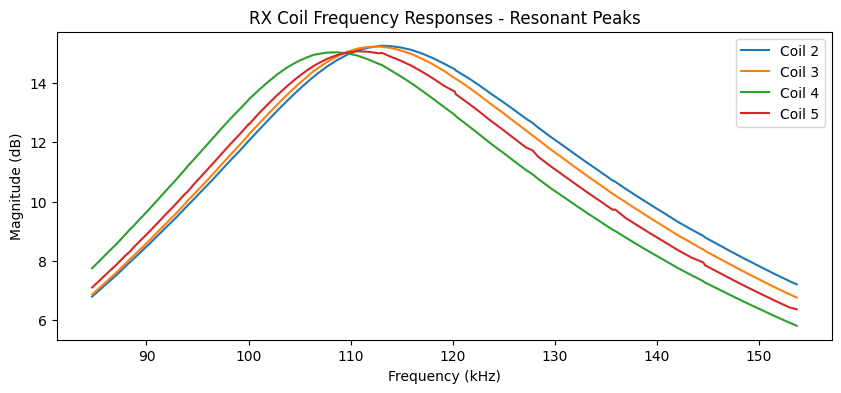

In [84]:
plt.figure(figsize=(10,4))
plt.plot(freq2[130:205]*1e-3, mag2[130:205], label='Coil 2')
plt.plot(freq3[130:205]*1e-3, mag3[130:205], label='Coil 3')
plt.plot(freq4[130:205]*1e-3, mag4[130:205], label='Coil 4')
plt.plot(freq5[130:205]*1e-3, mag5[130:205], label='Coil 5')

plt.title('RX Coil Frequency Responses - Resonant Peaks')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

# print(len(freq2))

In [93]:
res2 = get_res_freq(freq2, mag2)
res3 = get_res_freq(freq3, mag3)
res4 = get_res_freq(freq4, mag4)
res5 = get_res_freq(freq5, mag5)

print(f'Coil 2 Resonant Frequency: {res2*1e-3:.2f} kHz')
print(f'Coil 3 Resonant Frequency: {res3*1e-3:.2f} kHz')
print(f'Coil 4 Resonant Frequency: {res4*1e-3:.2f} kHz')
print(f'Coil 5 Resonant Frequency: {res5*1e-3:.2f} kHz')

avg_res = np.mean([res2, res3, res4, res5])
res_std = np.std([res2, res3, res4, res5])
print(f'\nOverall Resonant Frequency: {avg_res*1e-3:.2f} kHz \u00B1 {res_std*1e-3:.2f} kHz')

Coil 2 Resonant Frequency: 113.07 kHz
Coil 3 Resonant Frequency: 112.77 kHz
Coil 4 Resonant Frequency: 108.67 kHz
Coil 5 Resonant Frequency: 110.70 kHz

Overall Resonant Frequency: 111.30 kHz ± 1.77 kHz


In [102]:
L2 = calc_ind(res2)
L3 = calc_ind(res3)
L4 = calc_ind(res4)
L5 = calc_ind(res5)

print(f'Inductance of Coil 2: {L2*1e6:.2f} \u03BCH')
print(f'Inductance of Coil 3: {L3*1e6:.2f} \u03BCH')
print(f'Inductance of Coil 4: {L4*1e6:.2f} \u03BCH')
print(f'Inductance of Coil 5: {L5*1e6:.2f} \u03BCH')

avg_L = np.mean([L2, L3, L4, L5])
L_std = np.std([L2, L3, L4, L5])
print(f'\nOverall RX Coil Inductance: {avg_L*1e6:.2f} \u03BCH \u00B1 {L_std*1e6:.2f} \u03BCH')

Inductance of Coil 2: 9.01 μH
Inductance of Coil 3: 9.05 μH
Inductance of Coil 4: 9.75 μH
Inductance of Coil 5: 9.40 μH

Overall RX Coil Inductance: 9.30 μH ± 0.30 μH


In [136]:
Q2 = get_Q_factor(freq2, mag2)
Q3 = get_Q_factor(freq3, mag3)
Q4 = get_Q_factor(freq4, mag4)
Q5 = get_Q_factor(freq5, mag5)

print(f'Coil 2 Q Factor: {Q2:.2f}')
print(f'Coil 3 Q Factor: {Q3:.2f}')
print(f'Coil 4 Q Factor: {Q4:.2f}')
print(f'Coil 5 Q Factor: {Q5:.2f}')

Coil 2 Q Factor: 3.83
Coil 3 Q Factor: 3.85
Coil 4 Q Factor: 3.85
Coil 5 Q Factor: 3.82


**Conclusion: RX coils have slightly significant differences (?) which should be accounted for**

**Conclusion: the addition header pins does not effect the frequency response**

---

Now looking RLC circuits using Coil 5 and various resistane values:

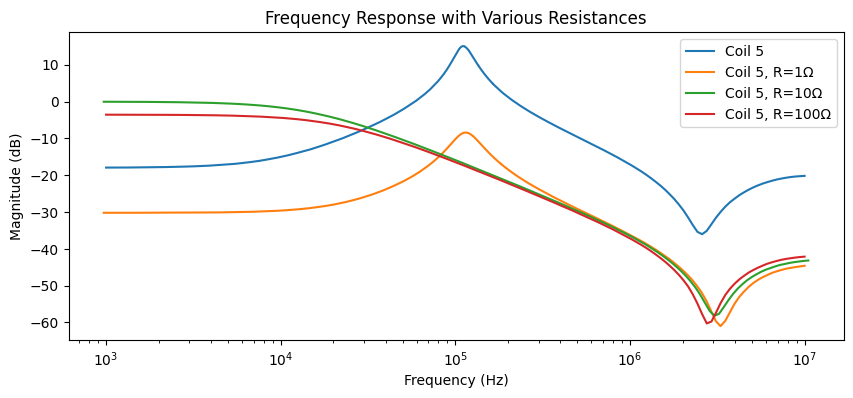

In [113]:
freq_R1, mag_R1 = merge_data('LC_coils_11-13/coil5_R1_freq.csv', 'LC_coils_11-13/coil5_R1_freq_zoomed.csv')

dfR10 = pd.read_csv('LC_coils_11-13/coil5_R10_freq.csv', comment='#')
dfR100 = pd.read_csv('LC_coils_11-13/coil5_R100_freq.csv', comment='#')

plt.figure(figsize=(10,4))
plt.semilogx(freq5, mag5, label='Coil 5')
plt.semilogx(freq_R1, mag_R1, label='Coil 5, R=1\u03A9')
plt.semilogx(dfR10['Frequency (Hz)'], dfR10['Channel 4 Magnitude (dB)'], label='Coil 5, R=10\u03A9')
plt.semilogx(dfR100['Frequency (Hz)'], dfR100['Channel 4 Magnitude (dB)'], label='Coil 5, R=100\u03A9')
plt.title('Frequency Response with Various Resistances')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

**Conclusion: Resistances >=10 damp out the resonant peak and should not be used for data collection**

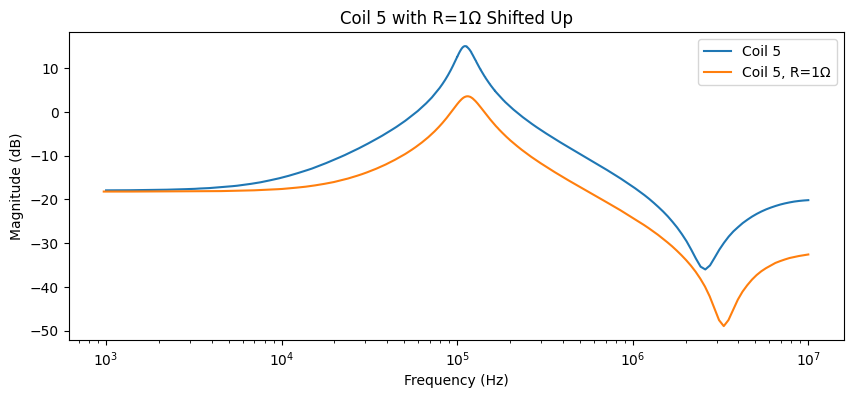

In [131]:
# print(mag5.iloc[0])
# print(mag_R1.iloc[0])

plt.figure(figsize=(10,4))
plt.semilogx(freq5, mag5, label='Coil 5')
plt.semilogx(freq_R1, mag_R1+12, label='Coil 5, R=1\u03A9')
plt.title('Coil 5 with R=1\u03A9 Shifted Up')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

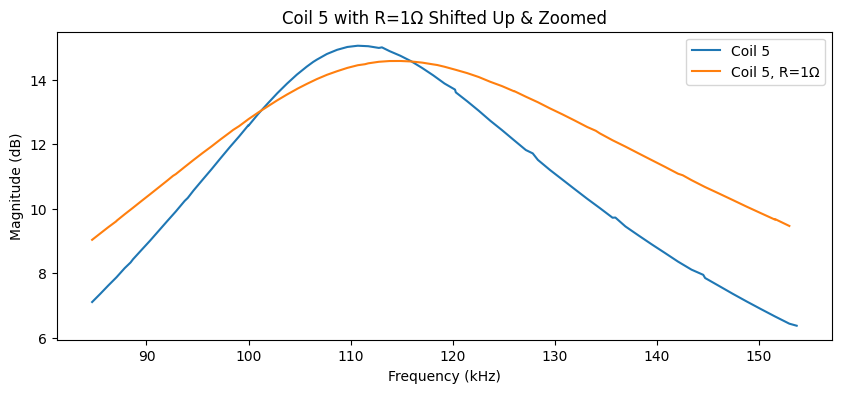

In [128]:
plt.figure(figsize=(10,4))
plt.plot(freq5[130:205]*1e-3, mag5[130:205], label='Coil 5')
plt.plot(freq_R1[130:205]*1e-3, mag_R1[130:205]+23, label='Coil 5, R=1\u03A9')
plt.title('Coil 5 with R=1\u03A9 Shifted Up & Zoomed')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.show()

In [137]:
res_R1 = get_res_freq(freq_R1, mag_R1)

print(f'Coil 5 Resonant Frequency: {res5*1e-3:.2f} kHz')
print(f'Coil 5 Resonant Frequency with R=1\u03A9: {res_R1*1e-3:.2f} kHz')

Coil 5 Resonant Frequency: 110.70 kHz
Coil 5 Resonant Frequency with R=1Ω: 114.87 kHz


In [138]:
QR1 = get_Q_factor(freq_R1, mag_R1)

print(f'Coil 5 Q Factor: {Q5:.2f}')
print(f'Coil 5 Q Factor with R=1\u03A9: {QR1:.2f}')

Coil 5 Q Factor: 3.82
Coil 5 Q Factor with R=1Ω: 2.56


**Conclusion: Presence of resistive load significantly impacts the resonant frequency**

In [167]:
well_df = pd.read_csv('LC_coils_11-13/well_merged.csv')

print('RX Coil Amplitude for various coils/resistors:')

for _, row in well_df.iterrows():
    file = row['File Name']
    file = file[:-4].replace('_', ' ')
    
    RX_amp = row['RX Amplitude (V)']

    print(f'{file:<12}  {RX_amp} V')

RX Coil Amplitude for various coils/resistors:
coil2         4.9151 V
coil3         4.5314 V
coil4         3.946 V
coil5 R1      3.3823 V
coil5 R10     0.8436 V
coil5 R100    0.09658 V
coil5         4.107 V


Note: shouldn't read too much into the actual magnitude of the readings because positions may have changed between tests, instead look at order of magnitude. 

**Conclusion: Presence of load significantly decreases amplitude of induced voltage in RX coil**